In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

class BinomialAsset:
    def __init__(self, p=0.6, up_return=1.1, down_return=0.9):
        self.p = p
        self.up_return = up_return
        self.down_return = down_return
        
    def sample(self):
        return self.up_return if np.random.random() < self.p else self.down_return

@jit(nopython=True)
def calculate_theoretical_allocation_pct(wealth, step, max_steps, p, a, b, r, risk_aversion):
    steps_remaining = max_steps - step
    if steps_remaining <= 0:
        return 0.0
    numerator = np.log(p * (a - r) / ((1 - p) * (r - b)))
    denominator = risk_aversion * (1 + r) ** steps_remaining * (a - b)
    result = numerator / denominator / wealth
    return min(max(result, 0.0), 1.0)

class PortfolioEnvironment:
    def __init__(self, max_steps, initial_wealth, risk_free_rate, risky_asset, risk_aversion, intermediate_reward=False):
        self.max_steps = max_steps
        self.initial_wealth = initial_wealth
        self.risk_free_rate = risk_free_rate
        self.risk_free_return = 1 + risk_free_rate
        self.risky_asset = risky_asset
        self.risk_aversion = risk_aversion
        self.p = risky_asset.p
        self.a = risky_asset.up_return - 1
        self.b = risky_asset.down_return - 1
        self.r = self.risk_free_return - 1
        self.intermediate_reward = intermediate_reward
        self.agent_actions = None  # Will be set later with agent's action space
        self.reset()
    
    def reset(self):
        self.wealth = self.initial_wealth
        self.step_count = 0
        steps_remaining = self.max_steps - self.step_count
        return np.array([self.wealth, steps_remaining])  # Use steps_remaining instead of step_count
    
    def get_theoretical_allocation_pct(self, state):
        wealth, step = state
        return calculate_theoretical_allocation_pct(
            wealth, step, self.max_steps, self.p, self.a, self.b, self.r, self.risk_aversion
        )
    
    def get_theoretical_allocation_pct_mapped(self, state):
        """
        Get the theoretical allocation percentage and map it to the nearest
        available action in the action space.
        
        Parameters:
        -----------
        state : array-like
            The state for which to calculate the theoretical allocation
        
        Returns:
        --------
        float
            The theoretical allocation mapped to the nearest available action
        """
        # Get the continuous theoretical allocation
        theoretical_alloc = self.get_theoretical_allocation_pct(state)
        
        # Find the index of the closest action in the action space
        if self.agent_actions is not None:
            action_idx = np.argmin(np.abs(self.agent_actions - theoretical_alloc))
            # Return the mapped action
            return self.agent_actions[action_idx]
        else:
            # If agent_actions isn't set, return the continuous value
            return theoretical_alloc
    
    def step(self, action):
        action = np.clip(action, 0, 1)
        risky_return = self.risky_asset.sample()
        portfolio_return = action * risky_return + (1 - action) * self.risk_free_return
        prev_wealth = self.wealth
        self.wealth *= portfolio_return
        self.step_count += 1
        done = self.step_count >= self.max_steps
        
        # Reward shaping: wealth growth + terminal utility
        if self.intermediate_reward:
            growth_reward = (self.wealth - prev_wealth) * 10  # Amplify wealth change
            terminal_reward = (1 - np.exp(-self.risk_aversion * self.wealth)) / self.risk_aversion * 100 if done else 0
            reward = growth_reward + terminal_reward
        else:
            terminal_reward = (1 - np.exp(-self.risk_aversion * self.wealth)) / self.risk_aversion * 100 if done else 0
            reward = terminal_reward
        
        next_state = np.array([self.wealth, self.max_steps - self.step_count])  # Return steps_remaining
        
        # Get continuous theoretical allocation
        theoretical_alloc = self.get_theoretical_allocation_pct(next_state)
        
        # Get mapped theoretical allocation
        theoretical_alloc_mapped = self.get_theoretical_allocation_pct_mapped(next_state)
        
        info = {
            'action': action,
            'theoretical_alloc': theoretical_alloc,
            'theoretical_alloc_mapped': theoretical_alloc_mapped,
            'difference': abs(action - theoretical_alloc),
            'difference_mapped': abs(action - theoretical_alloc_mapped),
            'wealth': self.wealth
        }
        
        return next_state, reward, done, info

class SARSAAgentWithVisitCounts:
    def __init__(self, env, n_wealth_bins=25, learning_rate=0.1, gamma=0.99, 
                 epsilon_start=1.0, epsilon_end=0.01, n_actions=21, episodes=100000,
                 policy_probs=[0.33, 0.33, 0.34]):  # Probabilities for each policy type
        self.env = env
        self.alpha = learning_rate
        self.gamma = gamma
        self.epsilon_start = epsilon_start
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.num_episodes = episodes
        self.n_wealth_bins = n_wealth_bins
        self.n_time_steps = env.max_steps + 1
        self.wealth_bins = np.linspace(0, 5.0, n_wealth_bins + 1)
        self.n_actions = n_actions
        self.actions = np.linspace(0, 1, n_actions)
        self.q_table = np.ones((n_wealth_bins, self.n_time_steps, n_actions), dtype=np.float32) * 0.1
        
        # Set agent's action space in the environment
        env.agent_actions = self.actions
        
        # Initialize visit counts
        self.visit_counts = np.zeros((n_wealth_bins, self.n_time_steps, n_actions), dtype=np.int32)
        
        # Policy probabilities
        self.policy_probs = policy_probs  # [uniform, best_policy, least_frequent]
    
    def discretize_state(self, state):
        wealth, steps_remaining = state
        wealth_idx = np.clip(np.searchsorted(self.wealth_bins, wealth) - 1, 0, self.n_wealth_bins - 1)
        time_idx = min(max(steps_remaining, 0), self.n_time_steps - 1)
        return np.array([int(wealth_idx), int(time_idx)])
    
    def get_action(self, state, explore=True):
        state_idx = self.discretize_state(state)
        
        if explore and np.random.random() < self.epsilon:
            # Choose a policy based on policy_probs
            policy_type = np.random.choice(3, p=self.policy_probs)
            
            if policy_type == 0:
                # 1. Random uniform exploration
                action_idx = np.random.randint(self.n_actions)
                
            elif policy_type == 1:
                # 2. Best existing policy (exploitation)
                action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
                
            else:
                # 3. Least frequent walked path
                # Get the least visited actions for this state
                state_visits = self.visit_counts[state_idx[0], state_idx[1]]
                min_visits = np.min(state_visits)
                
                # Find all actions with minimum visits
                min_visit_indices = np.where(state_visits == min_visits)[0]
                
                # If there are multiple with the same minimum, choose based on Q-values
                if len(min_visit_indices) > 1:
                    # Select the one with the highest Q-value among the least visited
                    q_values_for_min_visits = self.q_table[state_idx[0], state_idx[1], min_visit_indices]
                    best_min_visit_idx = np.argmax(q_values_for_min_visits)
                    action_idx = min_visit_indices[best_min_visit_idx]
                else:
                    action_idx = min_visit_indices[0]
        else:
            # Always use the best policy when not exploring
            action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
        
        return self.actions[action_idx]
    
    def update(self, state, action, reward, next_state, next_action, done, episode):
        state_idx = self.discretize_state(state)
        action_idx = int(np.argmin(np.abs(self.actions - action)))
        
        # Update visit counts
        self.visit_counts[state_idx[0], state_idx[1], action_idx] += 1
        
        # Check how well-explored this state is
        state_visits = np.sum(self.visit_counts[state_idx[0], state_idx[1], :])
        
        # Use higher learning rate for less-explored states
        if state_visits < 100:
            learning_boost = 3.0  # Much higher learning rate for rare states
        elif state_visits < 1000:
            learning_boost = 2.0  # Higher learning rate for uncommon states
        else:
            learning_boost = 1.0  # Normal learning rate for common states
        
        alpha = (self.alpha / (1 + episode / 20000)) * learning_boost
        
        # Standard TD update (unchanged)
        q_current = self.q_table[state_idx[0], state_idx[1], action_idx]
        q_next = 0
        if not done:
            next_state_idx = self.discretize_state(next_state)
            next_action_idx = int(np.argmin(np.abs(self.actions - next_action)))
            q_next = self.q_table[next_state_idx[0], next_state_idx[1], next_action_idx]
        
        td_error = reward + self.gamma * q_next - q_current
        self.q_table[state_idx[0], state_idx[1], action_idx] += alpha * td_error
        
        return abs(td_error)
    
    def decay_epsilon(self, episode):
        # Slow epsilon decay
        progress = min(1.0, episode / (self.num_episodes))
        self.epsilon = max(self.epsilon_end, self.epsilon_start - progress * (self.epsilon_start - self.epsilon_end))
        
        # Adjust policy probabilities as training progresses
        # Start with more exploration, gradually shift to more exploitation
        exploration_weight = self.epsilon  # As epsilon decreases
        
        # Adjust policy probabilities: more uniform and least-frequent early on,
        # more best-policy later
        self.policy_probs = [
            0.4 * exploration_weight,                   # uniform random (decreases with time)
            0.2 + 0.6 * (1 - exploration_weight),       # best policy (increases with time)
            0.4 * exploration_weight + 0.2 * (1 - exploration_weight)  # least frequent (decreases but not to zero)
        ]
        
        # Normalize to ensure they sum to 1
        self.policy_probs = np.array(self.policy_probs) / sum(self.policy_probs)
    
    def get_best_action(self, state):
        state_idx = self.discretize_state(state)
        action_idx = np.argmax(self.q_table[state_idx[0], state_idx[1]])
        return self.actions[action_idx]
    
    def get_visit_statistics(self):
        # Calculate visit statistics
        total_visits = np.sum(self.visit_counts)
        max_visits = np.max(self.visit_counts)
        min_visits = np.min(self.visit_counts[self.visit_counts > 0]) if np.any(self.visit_counts > 0) else 0
        unvisited = np.sum(self.visit_counts == 0)
        
        return {
            "total_visits": total_visits,
            "max_visits": max_visits,
            "min_visits": min_visits,
            "unvisited": unvisited,
            "visit_std": np.std(self.visit_counts[self.visit_counts > 0]) if np.any(self.visit_counts > 0) else 0
        }

def train_tabular_sarsa(env, agent, num_episodes=100000, eval_interval=1000, verbose=True):
    rewards_history = []
    theoretical_diffs = []
    theoretical_diffs_mapped = []  # Track mapped differences
    actions_history = []
    td_errors_history = []
    visit_stats_history = []
    
    for episode in range(num_episodes):
        state = env.reset()
        action = agent.get_action(state, explore=True)
        total_reward = 0
        step_differences = []
        step_differences_mapped = []  # Track mapped differences
        step_actions = []
        td_errors = []
        
        done = False
        while not done:
            next_state, reward, done, info = env.step(action)
            step_differences.append(info['difference'])
            step_differences_mapped.append(info['difference_mapped'])  # Store mapped difference
            step_actions.append(action)
            next_action = agent.get_action(next_state, explore=True)
            td_error = agent.update(state, action, reward, next_state, next_action, done, episode)
            td_errors.append(td_error)
            total_reward += reward
            state = next_state
            action = next_action
        
        rewards_history.append(total_reward)
        
        if episode % eval_interval == 0:
            theoretical_diffs.append(np.mean(step_differences))
            theoretical_diffs_mapped.append(np.mean(step_differences_mapped))  # Store mapped diff
            actions_history.append(np.mean(step_actions))
            td_errors_history.append(np.mean(td_errors))
            
            # Get visit statistics
            if hasattr(agent, 'get_visit_statistics'):
                visit_stats = agent.get_visit_statistics()
                visit_stats_history.append(visit_stats)
                
                if verbose and (episode % (10 * eval_interval) == 0 or episode == 0):
                    print(f"Episode {episode}: Reward = {np.mean(rewards_history[-eval_interval:]):.2f}, "
                          f"Theo Diff = {np.mean(step_differences):.4f}, "
                          f"Theo Diff Mapped = {np.mean(step_differences_mapped):.4f}, "
                          f"TD Error = {np.mean(td_errors):.6f}, "
                          f"Unvisited = {visit_stats['unvisited']}, "
                          f"Policy probs = {np.round(agent.policy_probs, 2)}")
            else:
                if verbose and (episode % (10 * eval_interval) == 0 or episode == 0):
                    print(f"Episode {episode}: Reward = {np.mean(rewards_history[-eval_interval:]):.2f}, "
                          f"Theo Diff = {np.mean(step_differences):.4f}, "
                          f"Theo Diff Mapped = {np.mean(step_differences_mapped):.4f}, "
                          f"TD Error = {np.mean(td_errors):.6f}")
            
            # Check convergence criteria (optional)
            if len(td_errors_history) >= 10 and np.mean(td_errors_history[-100:]) <= 0.5:
                print(f"Converged at episode {episode} with TD error {np.mean(td_errors_history[-10:]):.6f}")
                break
            
        agent.decay_epsilon(episode)
    
    result_dict = {
        'rewards': np.array(rewards_history),
        'theoretical_diffs': np.array(theoretical_diffs),
        'theoretical_diffs_mapped': np.array(theoretical_diffs_mapped),  # Include mapped diffs
        'actions': np.array(actions_history),
        'td_errors': np.array(td_errors_history)
    }
    
    if hasattr(agent, 'get_visit_statistics'):
        result_dict['visit_stats'] = visit_stats_history
    
    return result_dict

def moving_average(data, window_size=500):
    """
    Calculate a conventional moving average with the given window size.
    """
    result = np.zeros_like(data, dtype=float)
    
    # Fill initial points where we don't have a full window
    for i in range(min(window_size, len(data))):
        # For each early point, average what we have so far
        result[i] = np.mean(data[:i+1])
    
    # Calculate standard sliding window average for remaining points
    for i in range(window_size, len(data)):
        result[i] = np.mean(data[i-window_size+1:i+1])
        
    return result

def visualize_training(results, ma_window=500, show_raw=False, suffix='', env=None, save_fig=False):
    """
    Visualize training metrics with a conventional moving average.
    """
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    
    # Debug raw data
    print("Raw data lengths:")
    for key in ['rewards', 'theoretical_diffs', 'theoretical_diffs_mapped', 'actions', 'td_errors']:
        if key in results:
            print(f"  {key}: {len(results[key])}")
    
    # Indices
    reward_indices = np.arange(len(results['rewards']))
    eval_indices = np.linspace(0, len(results['rewards']) - 1, len(results['theoretical_diffs']), dtype=int)
    print(f"Indices: Rewards={len(reward_indices)}, Eval={len(eval_indices)}")
    
    # Moving averages
    ma_rewards = moving_average(results['rewards'], ma_window)
    ma_diffs = moving_average(results['theoretical_diffs'], ma_window)
    ma_diffs_mapped = moving_average(results['theoretical_diffs_mapped'], ma_window)
    ma_actions = moving_average(results['actions'], ma_window)
    ma_td_errors = moving_average(results['td_errors'], ma_window)
    
    # Debug MA
    print("MA lengths:")
    print(f"  MA rewards: {len(ma_rewards)}")
    print(f"  MA diffs: {len(ma_diffs)}")
    print(f"  MA diffs mapped: {len(ma_diffs_mapped)}")
    print(f"  MA actions: {len(ma_actions)}")
    print(f"  MA td errors: {len(ma_td_errors)}")
    
    # Plot 1: Theoretical difference (both regular and mapped)
    if len(results['theoretical_diffs']) > 0:
        axes[0].plot(eval_indices, ma_diffs, 'b-', linewidth=2, label=f'Theoretical Diff (window={ma_window})')
        axes[0].plot(eval_indices, ma_diffs_mapped, 'c--', linewidth=2, label=f'Mapped Diff (window={ma_window})')
        axes[0].set_title('Difference from Theoretical Optimal')
        axes[0].set_xlabel('Episode')
        axes[0].set_ylabel('Average Difference')
        axes[0].legend()
        print(f"Theo diffs plot: x={len(eval_indices)}, y_ma={len(ma_diffs)}, y_ma_mapped={len(ma_diffs_mapped)}")
    
    # Plot 2: Rewards
    if len(results['rewards']) > 0:
        axes[1].plot(reward_indices, ma_rewards, 'g-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[1].set_title('Total Rewards')
        axes[1].set_xlabel('Episode')
        axes[1].set_ylabel('Reward')
        axes[1].legend()
        print(f"Rewards plot: x={len(reward_indices)}, y_ma={len(ma_rewards)}")
    
    # Plot 3: Actions
    if len(results['actions']) > 0:
        axes[2].plot(eval_indices, ma_actions, 'r-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[2].set_title('Action Allocation')
        axes[2].set_xlabel('Episode')
        axes[2].set_ylabel('Average Allocation')
        if env:
            # Calculate continuous theoretical optimal
            wealth_vals = np.array([env.initial_wealth])
            time_vals = np.arange(env.max_steps + 1)
            theoretical_values = []
            for t in time_vals:
                theoretical_values.append(env.get_theoretical_allocation_pct([env.initial_wealth, t]))
            theoretical_mean = np.mean(theoretical_values)
            
            # Calculate mapped theoretical optimal
            theoretical_values_mapped = []
            for t in time_vals:
                theoretical_values_mapped.append(env.get_theoretical_allocation_pct_mapped([env.initial_wealth, t]))
            theoretical_mean_mapped = np.mean(theoretical_values_mapped)
            
            # Plot both theoretical lines
            axes[2].axhline(y=theoretical_mean, color='k', linestyle='--', label=f'Theoretical: {theoretical_mean:.4f}')
            axes[2].axhline(y=theoretical_mean_mapped, color='k', linestyle=':', label=f'Theo Mapped: {theoretical_mean_mapped:.4f}')
        
        axes[2].legend()
        print(f"Actions plot: x={len(eval_indices)}, y_ma={len(ma_actions)}")
    
    # Plot 4: TD Errors
    if len(results['td_errors']) > 0:
        axes[3].plot(eval_indices, ma_td_errors, 'm-', linewidth=2, label=f'Moving Avg (window={ma_window})')
        axes[3].set_title('TD Error')
        axes[3].set_xlabel('Episode')
        axes[3].set_ylabel('Average TD Error')
        axes[3].legend()
        print(f"TD errors plot: x={len(eval_indices)}, y_ma={len(ma_td_errors)}")
    
    plt.tight_layout()
    if save_fig:
        plt.savefig(f'training_metrics_ma_{suffix}.png')
    plt.show()

def visualize_visit_counts(agent, env):
    """
    Visualize the visit counts across the state-action space.
    """
    plt.figure(figsize=(15, 10))
    
    # Get a 2D view of visit counts by summing over actions
    visits_by_state = np.sum(agent.visit_counts, axis=2)
    
    # Plot as a heatmap
    plt.imshow(visits_by_state, aspect='auto', cmap='viridis')
    plt.colorbar(label='Visit Count')
    plt.title('State Visit Frequency')
    plt.xlabel('Time Step')
    plt.ylabel('Wealth Bin')
    
    # Add theoretical optimal overlay if env is provided
    if env:
        wealth_bins = agent.wealth_bins[:-1] + np.diff(agent.wealth_bins)/2
        time_steps = np.arange(agent.n_time_steps)
        
        # Compute theoretical optimal action for each state
        theo_actions = np.zeros((len(wealth_bins), len(time_steps)))
        theo_actions_mapped = np.zeros((len(wealth_bins), len(time_steps)))
        
        for i, w in enumerate(wealth_bins):
            for j, t in enumerate(time_steps):
                # Continuous theoretical
                theo_actions[i, j] = env.get_theoretical_allocation_pct([w, t])
                # Mapped theoretical 
                theo_actions_mapped[i, j] = env.get_theoretical_allocation_pct_mapped([w, t])
        
        # Overlay contours
        cont1 = plt.contour(theo_actions, levels=5, colors='red', alpha=0.7, linestyles='solid')
        cont2 = plt.contour(theo_actions_mapped, levels=5, colors='blue', alpha=0.7, linestyles='dashed')
        
        # Add contour labels
        plt.clabel(cont1, inline=True, fontsize=8, fmt='%.2f')
        plt.clabel(cont2, inline=True, fontsize=8, fmt='%.2f')
        
        # Add legend
        from matplotlib.lines import Line2D
        legend_elements = [
            Line2D([0], [0], color='red', lw=2, linestyle='-', label='Theoretical Optimal'),
            Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mapped Theoretical')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

def analyze_state_space(agent, env, num_episodes=1000):
    """Analyze which parts of the state space are reachable"""
    
    # Create a map of potentially reachable states
    reachable = np.zeros((agent.n_wealth_bins, agent.n_time_steps), dtype=bool)
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            state_idx = agent.discretize_state(state)
            reachable[state_idx[0], state_idx[1]] = True
            
            # Take random actions to explore widely
            action = agent.actions[np.random.randint(agent.n_actions)]
            state, _, done, _ = env.step(action)
    
    # Report results
    total_states = agent.n_wealth_bins * agent.n_time_steps
    reachable_count = np.sum(reachable)
    print(f"Analysis complete: {reachable_count}/{total_states} states are reachable ({reachable_count/total_states:.2%})")
    
    # Visualize reachable states
    plt.figure(figsize=(10, 6))
    plt.imshow(reachable, cmap='viridis', aspect='auto')
    plt.colorbar(label='Reachable')
    plt.title('Reachable States in State Space')
    plt.xlabel('Time Step')
    plt.ylabel('Wealth Bin')
    plt.show()
    
    return reachable

    

# Xt ~1 case

Episode 0: Reward = 185.72, Theo Diff = 0.4635, Theo Diff Mapped = 0.4650, TD Error = 18.562456, Unvisited = 5765, Policy probs = [0.66 0.   0.34]
Episode 10000: Reward = 142.99, Theo Diff = 0.4972, Theo Diff Mapped = 0.5000, TD Error = 9.655778, Unvisited = 3022, Policy probs = [0.4 0.2 0.4]
Episode 20000: Reward = 142.63, Theo Diff = 0.5391, Theo Diff Mapped = 0.5400, TD Error = 10.426751, Unvisited = 2939, Policy probs = [0.4 0.2 0.4]
Episode 30000: Reward = 142.76, Theo Diff = 0.3839, Theo Diff Mapped = 0.3850, TD Error = 7.013593, Unvisited = 2899, Policy probs = [0.4  0.21 0.4 ]
Episode 40000: Reward = 142.03, Theo Diff = 0.3989, Theo Diff Mapped = 0.3950, TD Error = 11.285398, Unvisited = 2877, Policy probs = [0.39 0.21 0.4 ]
Episode 50000: Reward = 142.36, Theo Diff = 0.5658, Theo Diff Mapped = 0.5650, TD Error = 7.944948, Unvisited = 2865, Policy probs = [0.39 0.21 0.4 ]
Episode 60000: Reward = 145.33, Theo Diff = 0.2825, Theo Diff Mapped = 0.2750, TD Error = 8.687139, Unvisit

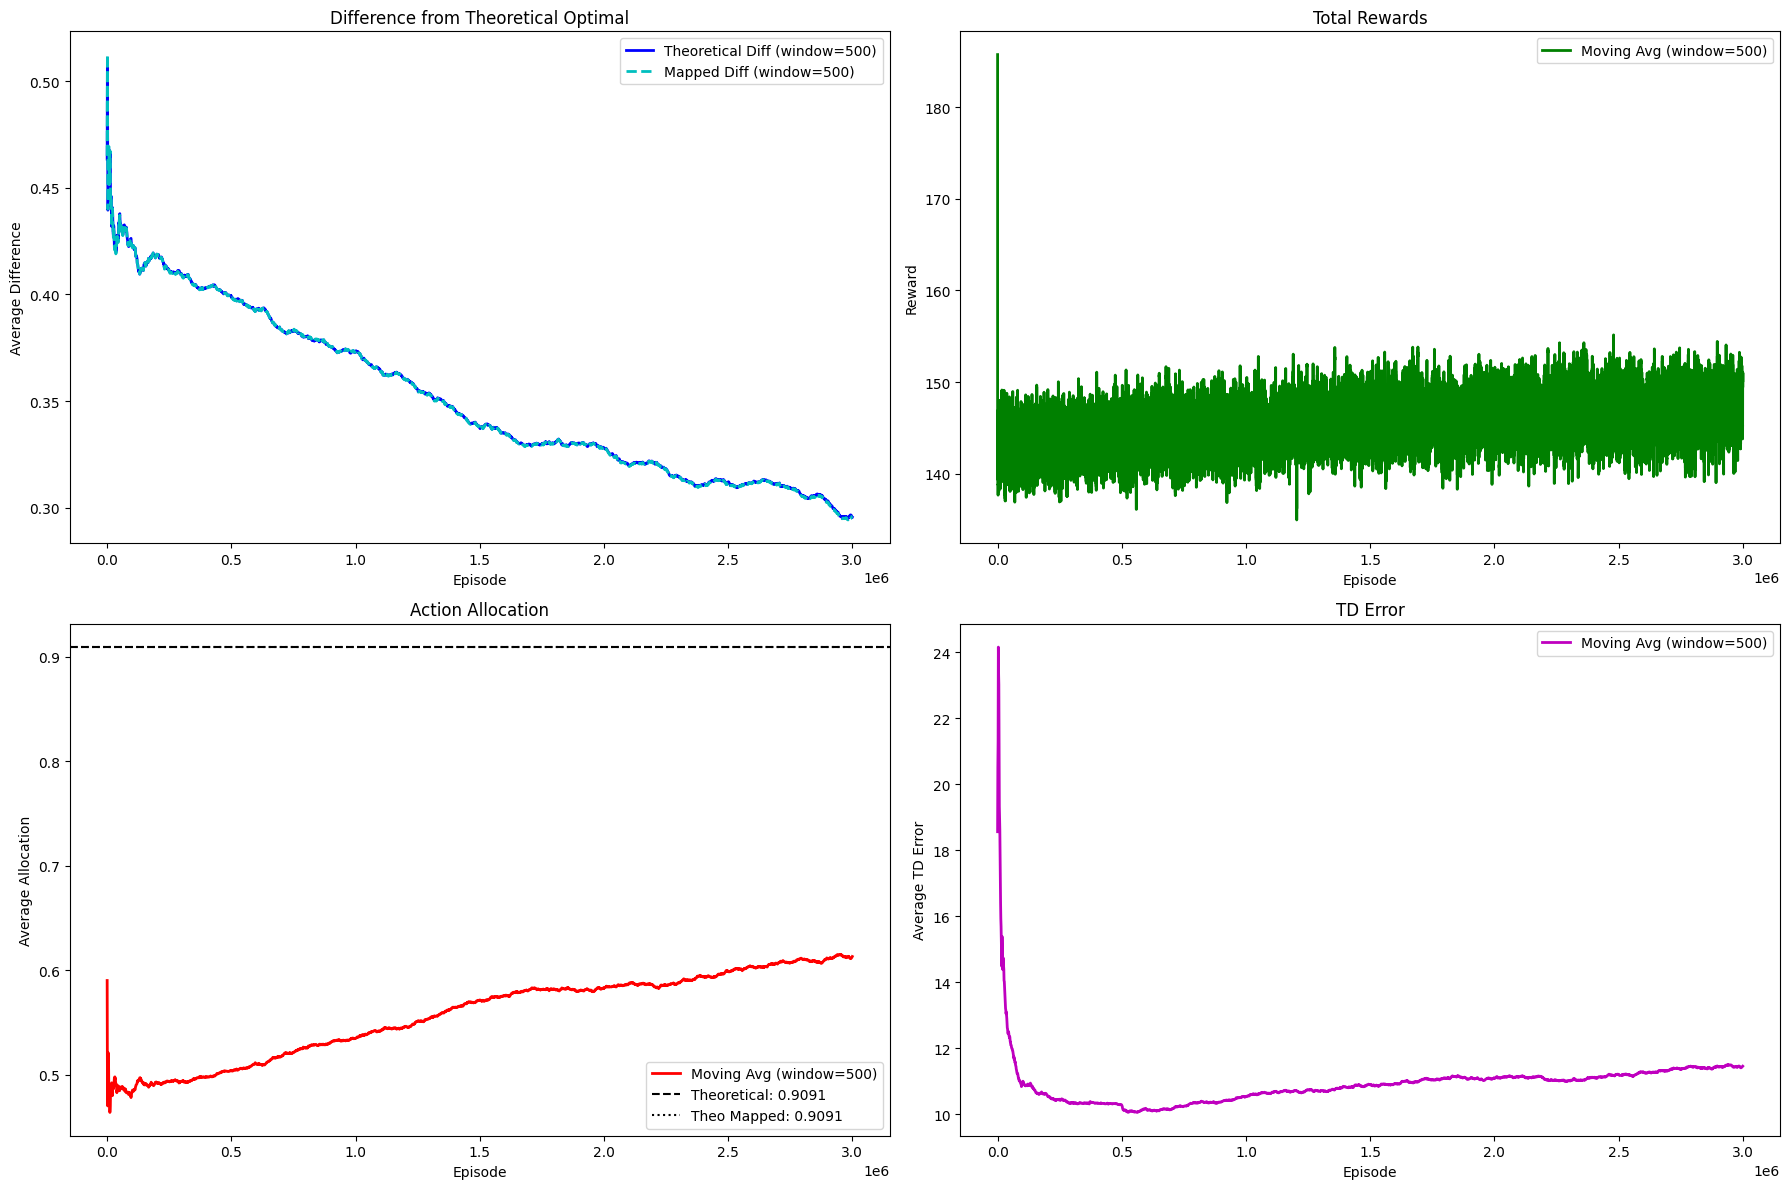

In [2]:
risky_asset_xtmid = BinomialAsset(
    p=0.7,                # Moderate probability of up movement  
    up_return=1.3,       # Moderate up return
    down_return=0.7       # Moderate downside
)
env_xtmid = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.06,  # Slightly higher risk-free rate
    risky_asset=risky_asset_xtmid,
    risk_aversion=0.4      # Moderate-to-low risk aversion
)

# Use the agent with visit counts
agent_xtmid = SARSAAgentWithVisitCounts(
    env_xtmid,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000,
    policy_probs=[0.66, 0, 0.34]  # Initial probabilities for each policy type
)

# Analyze reachable states before training (optional)
# reachable_map = analyze_state_space(agent, env, num_episodes=5000)

np.random.seed(42)
results_xtmid = train_tabular_sarsa(env_xtmid, agent_xtmid, num_episodes=agent_xtmid.num_episodes)
visualize_training(results_xtmid, env=env_xtmid,save_fig=True,suffix='final_xtmid')


# Xt = 1 Case

Episode 0: Reward = 140.52, Theo Diff = 0.4100, Theo Diff Mapped = 0.4100, TD Error = 14.043145, Unvisited = 5765, Policy probs = [0.66 0.   0.34]
Episode 10000: Reward = 126.99, Theo Diff = 0.4750, Theo Diff Mapped = 0.4750, TD Error = 3.277661, Unvisited = 5085, Policy probs = [0.4 0.2 0.4]
Episode 20000: Reward = 126.39, Theo Diff = 0.4600, Theo Diff Mapped = 0.4600, TD Error = 2.733212, Unvisited = 5054, Policy probs = [0.4 0.2 0.4]
Episode 30000: Reward = 126.84, Theo Diff = 0.5000, Theo Diff Mapped = 0.5000, TD Error = 2.417439, Unvisited = 5036, Policy probs = [0.4  0.21 0.4 ]
Episode 40000: Reward = 126.56, Theo Diff = 0.5300, Theo Diff Mapped = 0.5300, TD Error = 1.944890, Unvisited = 5025, Policy probs = [0.39 0.21 0.4 ]
Episode 50000: Reward = 126.97, Theo Diff = 0.5400, Theo Diff Mapped = 0.5400, TD Error = 2.314177, Unvisited = 5014, Policy probs = [0.39 0.21 0.4 ]
Episode 60000: Reward = 128.34, Theo Diff = 0.4300, Theo Diff Mapped = 0.4300, TD Error = 3.133597, Unvisited

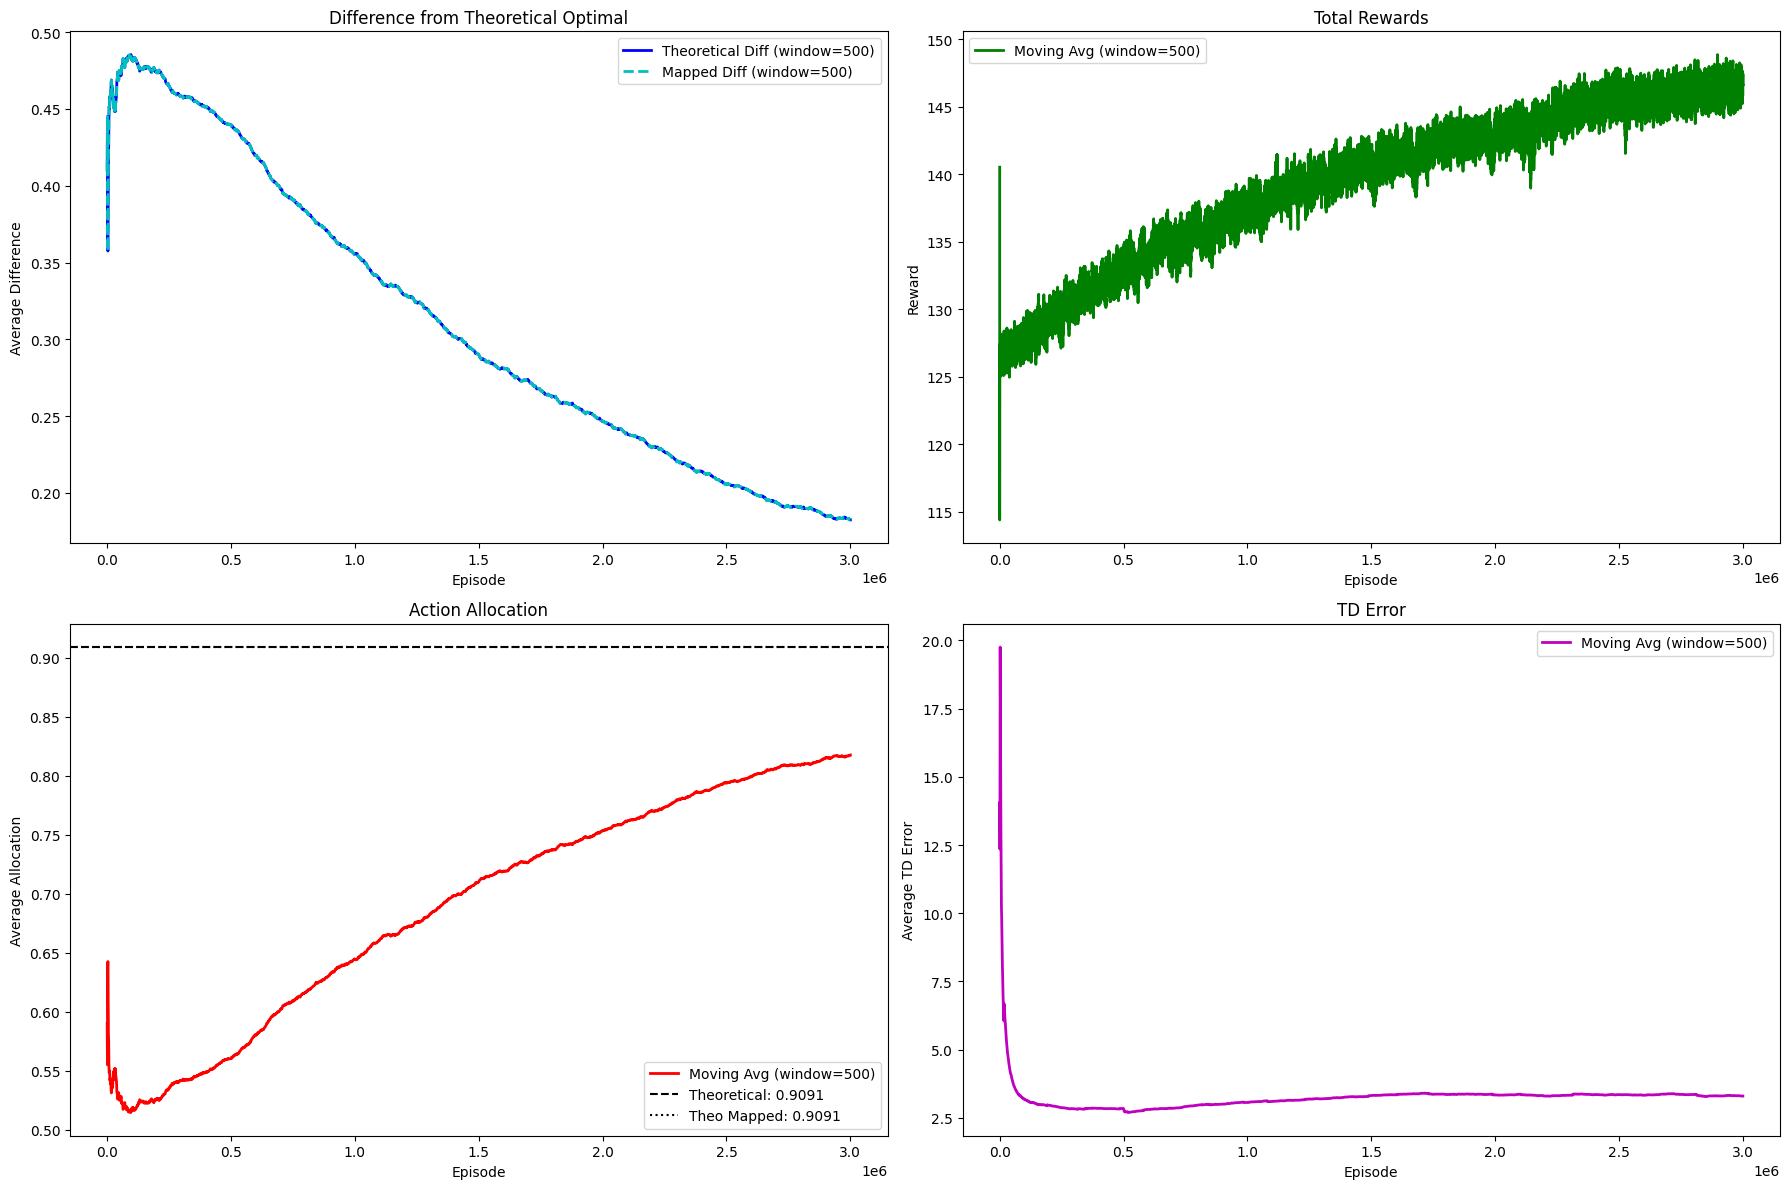

In [5]:
risky_asset_xt1 = BinomialAsset(
    p=0.7,               # Moderate probability of up movement  
    up_return=1.1,       # Moderate up return
    down_return=0.99        # Moderate downside
)
env_xt1 = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.01,   # Standard risk-free rate
    risky_asset=risky_asset_xt1,
    risk_aversion=0.2
)

# Use the agent with visit counts
agent_xt1 = SARSAAgentWithVisitCounts(
    env_xt1,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000,
    policy_probs=[0.66, 0, 0.34]  # Initial probabilities for each policy type
)

# Analyze reachable states before training (optional)
# reachable_map = analyze_state_space(agent, env, num_episodes=5000)

np.random.seed(42)
results_xt1 = train_tabular_sarsa(env_xt1, agent_xt1, num_episodes=agent_xt1.num_episodes)
visualize_training(results_xt1, env=env_xt1,save_fig=True,suffix='final_xt1')


# Xt = 0 Case

Episode 0: Reward = 53.75, Theo Diff = 0.5900, Theo Diff Mapped = 0.5900, TD Error = 5.365421, Unvisited = 5765, Policy probs = [0.66 0.   0.34]
Episode 10000: Reward = 56.79, Theo Diff = 0.3050, Theo Diff Mapped = 0.3050, TD Error = 1.112126, Unvisited = 5211, Policy probs = [0.4 0.2 0.4]
Episode 20000: Reward = 57.55, Theo Diff = 0.4650, Theo Diff Mapped = 0.4650, TD Error = 0.991250, Unvisited = 5195, Policy probs = [0.4 0.2 0.4]
Episode 30000: Reward = 57.32, Theo Diff = 0.6550, Theo Diff Mapped = 0.6550, TD Error = 1.018835, Unvisited = 5177, Policy probs = [0.4  0.21 0.4 ]
Episode 40000: Reward = 58.27, Theo Diff = 0.4650, Theo Diff Mapped = 0.4650, TD Error = 0.688095, Unvisited = 5170, Policy probs = [0.39 0.21 0.4 ]
Episode 50000: Reward = 57.92, Theo Diff = 0.6300, Theo Diff Mapped = 0.6300, TD Error = 1.215193, Unvisited = 5166, Policy probs = [0.39 0.21 0.4 ]
Episode 60000: Reward = 58.05, Theo Diff = 0.4750, Theo Diff Mapped = 0.4750, TD Error = 1.060153, Unvisited = 5163,

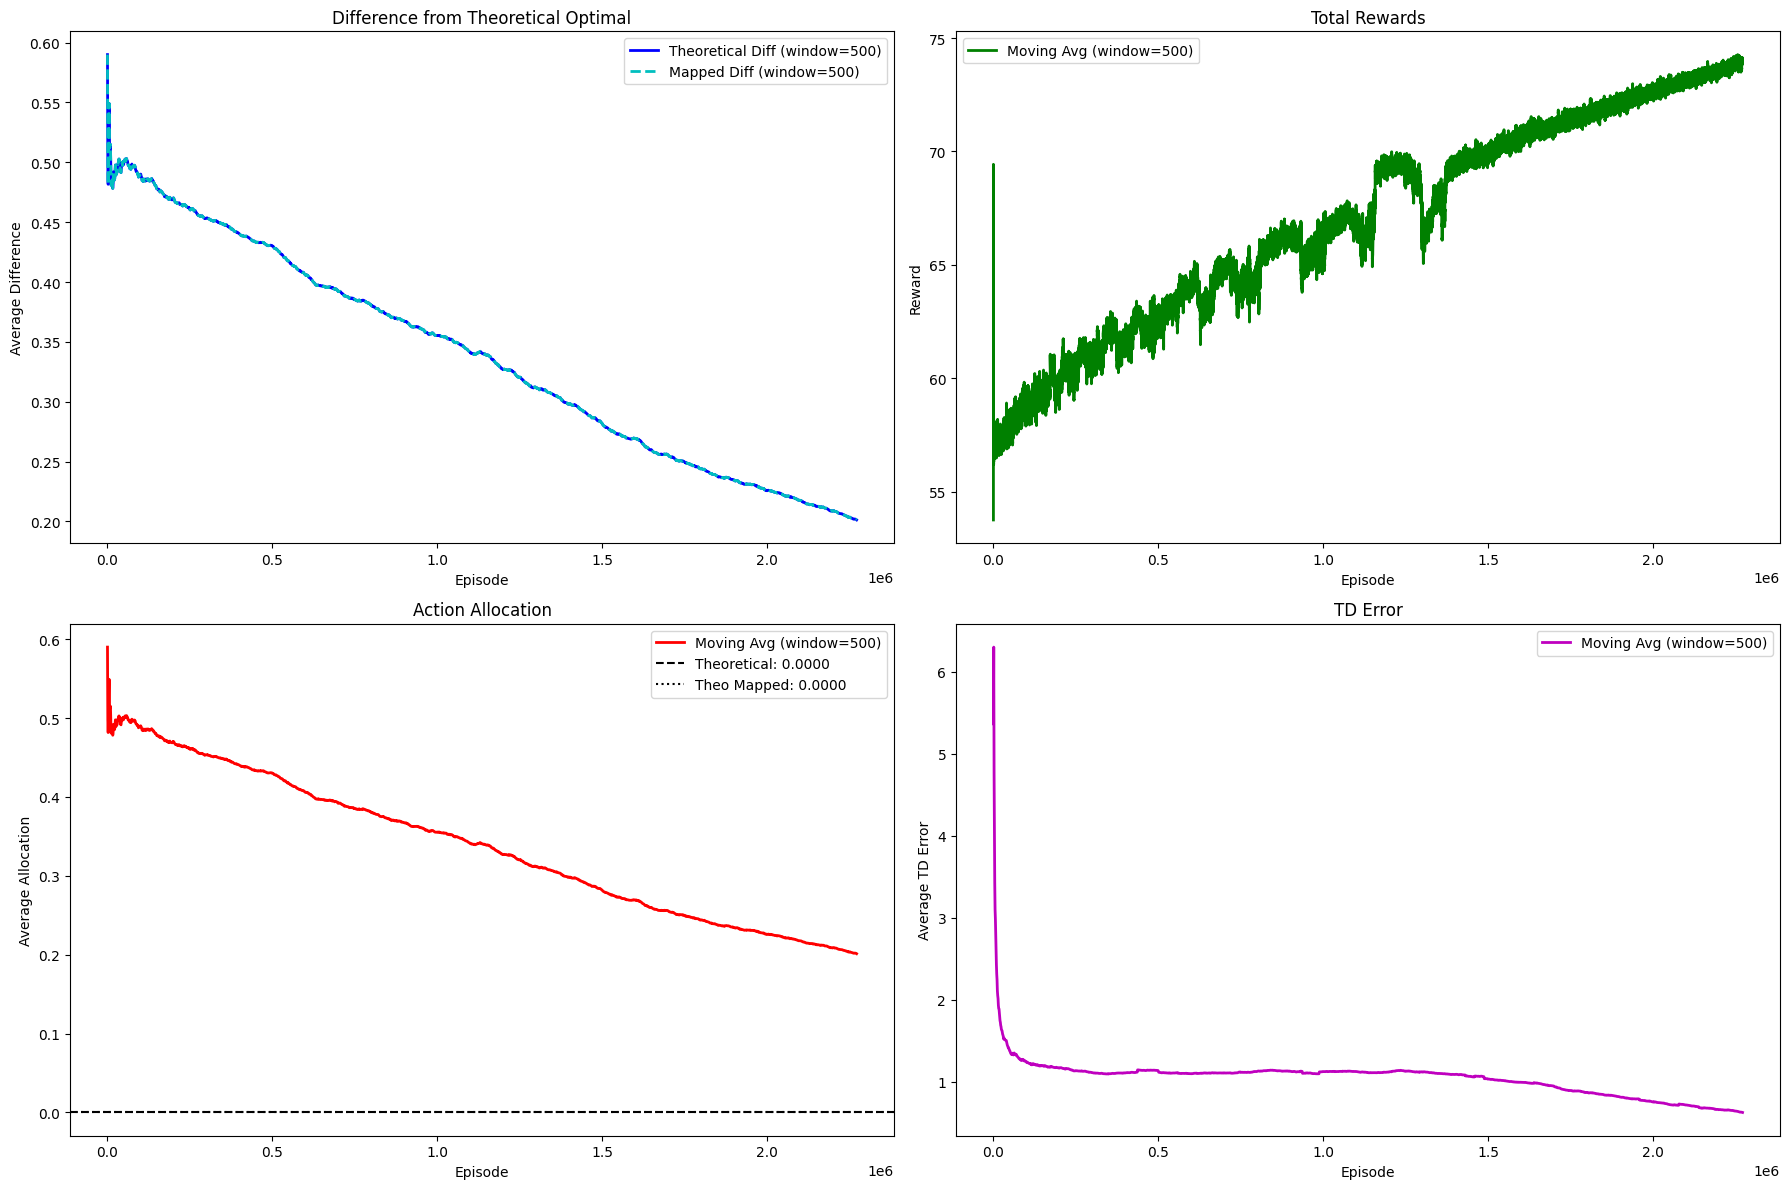

In [4]:
risky_asset_xt0 = BinomialAsset(
    p=0.1,               # Moderate probability of up movement  
    up_return=1.011,       # Moderate up return
    down_return=0.9        # Moderate downside
)
env_xt0 = PortfolioEnvironment(
    max_steps=10,
    initial_wealth=1.0,
    risk_free_rate=0.01,   # Standard risk-free rate
    risky_asset=risky_asset_xt0,
    risk_aversion=0.5      # Moderate risk aversion
)

# Use the agent with visit counts
agent_xt0 = SARSAAgentWithVisitCounts(
    env_xt0,
    n_wealth_bins=25,
    learning_rate=0.2,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_end=0.05,
    n_actions=21,
    episodes=3000000,
    policy_probs=[0.66, 0, 0.34]  # Initial probabilities for each policy type
)

# Analyze reachable states before training (optional)
# reachable_map = analyze_state_space(agent, env, num_episodes=5000)

np.random.seed(42)
results_xt0 = train_tabular_sarsa(env_xt0, agent_xt0, num_episodes=agent_xt0.num_episodes)
visualize_training(results_xt0, env=env_xt0,save_fig=True,suffix='final_xt0')

# Unit test

In [17]:
import ipytest
import pytest
import numpy as np
from unittest.mock import patch

# Configure ipytest
ipytest.autoconfig()

# Fixtures to create reusable objects
@pytest.fixture
def binomial_asset():
    return BinomialAsset(p=0.5, up_return=1.1, down_return=0.9)

@pytest.fixture
def env(binomial_asset):
    return PortfolioEnvironment(
        max_steps=10,
        initial_wealth=1.0,
        risk_free_rate=0.02,
        risky_asset=binomial_asset,
        risk_aversion=1.0,
        intermediate_reward=False
    )

@pytest.fixture
def agent(env):
    return SARSAAgentWithVisitCounts(
        env=env,
        n_wealth_bins=25,
        learning_rate=0.1,
        gamma=0.99,
        epsilon_start=1.0,
        epsilon_end=0.01,
        n_actions=21,
        episodes=100000,
        policy_probs=[0.4, 0.2, 0.4]  # [random, best_action, least_frequent]
    )

# Test Environment Reset
def test_environment_reset(env):
    state = env.reset()
    assert state[0] == 1.0, "Initial wealth should be 1.0"
    assert state[1] == 10, "Initial steps remaining should be 10"
    assert env.step_count == 0, "Step count should be 0 after reset"
    assert env.wealth == 1.0, "Wealth should be 1.0 after reset"

# Test Environment Step
def test_environment_step(env):
    env.reset()
    action = 0.5  # Allocate 50% to risky asset
    with patch.object(env.risky_asset, 'sample', return_value=1.1):
        next_state, reward, done, _ = env.step(action)
    expected_wealth = 1.0 * (0.5 * 1.1 + 0.5 * 1.02)  # 50% risky, 50% risk-free
    assert next_state[0] == pytest.approx(expected_wealth), "Wealth not updated correctly"
    assert next_state[1] == 9, "Steps remaining should decrease by 1"
    assert not done, "Should not be done after first step"
    assert reward == 0, "Reward should be 0 when intermediate_reward=False"

    # Test terminal step
    env.step_count = 9
    with patch.object(env.risky_asset, 'sample', return_value=1.1):
        next_state, reward, done, _ = env.step(action)
    expected_wealth *= (0.5 * 1.1 + 0.5 * 1.02)
    expected_reward = (1 - np.exp(-1.0 * expected_wealth)) / 1.0 * 100
    assert next_state[0] == pytest.approx(expected_wealth), "Terminal wealth incorrect"
    assert next_state[1] == 0, "Steps remaining should be 0"
    assert done, "Should be done at max_steps"
    assert reward == pytest.approx(expected_reward), "Terminal reward incorrect"

# Test Theoretical Allocation
def test_calculate_theoretical_allocation_pct():
    # Assuming this function is defined in your notebook
    wealth = 1.0
    step = 9  # steps_remaining = 1
    max_steps = 10
    p = 0.7
    a = 0.1
    b = -0.05
    r = 0.02
    risk_aversion = 1.0
    alloc = calculate_theoretical_allocation_pct(wealth, step, max_steps, p, a, b, r, risk_aversion)
    # Expected: log(0.7*(0.1-0.02)/(0.3*(0.02-(-0.05)))) / (1.0 * 1.02 * 0.15) ≈ 1.0 (clipped)
    assert alloc == 1.0, "Theoretical allocation should be 1.0"

# Test State Discretization
def test_discretize_state(agent):
    state = np.array([0.3, 3])
    discrete_state = agent.discretize_state(state)
    # wealth_bins = np.linspace(0, 5.0, 25+1), so step=0.2, 0.3 is in bin 1 (0.2 to 0.4)
    assert discrete_state[0] == 1, "Wealth=0.3 should be in bin 1"
    assert discrete_state[1] == 3, "Steps remaining=3 should map to time_idx=3"

    state = np.array([5.0, 0])
    discrete_state = agent.discretize_state(state)
    assert discrete_state[0] == 24, "Wealth=5.0 should be in last bin (24)"
    assert discrete_state[1] == 0, "Steps remaining=0 should map to time_idx=0"

# Test Action Selection
def test_get_action(agent):
    state = np.array([1.0, 5])
    agent.epsilon = 0.0  # Greedy
    # wealth=1.0 -> bin 4 (0.8 to 1.0), time_idx=5
    agent.q_table[4, 5, :] = 0.1
    agent.q_table[4, 5, 10] = 1.0  # Action 10 -> 0.5
    action = agent.get_action(state, explore=False)
    assert action == pytest.approx(0.5), "Should select action with highest Q-value (0.5)"

    # Test exploration (policy_type=0: uniform random)
    agent.epsilon = 1.0
    with patch('numpy.random.random', return_value=0.0):
        with patch('numpy.random.choice', return_value=0):
            with patch('numpy.random.randint', return_value=5):
                action = agent.get_action(state, explore=True)
                assert action == pytest.approx(0.25), "Should select random action (0.25)"
# Test Q-table Update
def test_update(agent):
    state = np.array([1.0, 5])
    action = 0.5  # action_idx=10
    reward = 1.0
    next_state = np.array([1.1, 4])
    next_action = 0.55  # action_idx=11
    done = False
    episode = 0

    state_idx = agent.discretize_state(state)  # [4, 5]
    next_state_idx = agent.discretize_state(next_state)  # [5, 4]
    initial_q = agent.q_table[4, 5, 10]
    agent.update(state, action, reward, next_state, next_action, done, episode)
    q_next = agent.q_table[5, 4, 11]
    td_error = reward + agent.gamma * q_next - initial_q
    expected_q = initial_q + 0.3 * td_error  # learning_rate * boost=0.1*3.0
    assert agent.q_table[4, 5, 10] == pytest.approx(expected_q), "Q-value update incorrect"
    assert agent.visit_counts[4, 5, 10] == 1, "Visit count should be 1"

# Test Epsilon Decay
def test_decay_epsilon(agent):
    agent.epsilon = 1.0
    agent.decay_epsilon(50000)
    expected_epsilon = max(0.01, 1.0 - (50000 / 100000) * (1.0 - 0.01))
    assert agent.epsilon == pytest.approx(expected_epsilon), "Epsilon decay incorrect at halfway"
    agent.decay_epsilon(100000)
    assert agent.epsilon == pytest.approx(0.01), "Epsilon should be at minimum"

In [18]:
# Run all tests
ipytest.run()

.........                                                                                    [100%]
9 passed in 0.04s


<ExitCode.OK: 0>